# Practical Assesment Task #1: Colorizing Images with Generative Adversarial Networks
Técnicas Generativas y Aprendizaje por Refuerzo - Curso 2024/2025



## Import Dependencies and Set General Parameters

In [1]:
# %pip install tensorflow -q
%pip install scikit-image -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import libraries
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Dense,
    Dropout, Flatten, LeakyReLU, UpSampling2D)
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from time import time
from skimage.color import rgb2lab, lab2rgb
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential

# Enable memory growth for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Constants
IMAGE_SIZE = 32
EPOCHS = 200 # Increase or decrease as appropriate
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 100

WORKDIR = "GANWorkspace"

# Create directories
Path(WORKDIR).mkdir(parents=True, exist_ok=True)
Path(f"{WORKDIR}/results").mkdir(parents=True, exist_ok=True)

## Define Dataset Loader

In [3]:
def generate_dataset(images, debug=False):
    """
    This function converts a list of RGB images to the LAB color space, and separates the L channel from the A and B channels.
    The images are normalized and reshaped to the appropriate dimensions for the model.

    Parameters:
    images (list): A list of RGB images
    debug (bool): If True, the function will display the original and converted images

    Returns:
    X (np.array): A numpy array of L channels of the images
    Y (np.array): A numpy array of A and B channels of the images
    """
    X = []
    Y = []

    for i in images:
        lab_image_array = rgb2lab(i / 255)  # Convert the image from RGB to LAB color space
        x = lab_image_array[:, :, 0]  # Get the L channel
        y = lab_image_array[:, :, 1:]  # Get the A and B channels
        y /= 128  # normalize

        if debug:  # If debug is True, display the original and converted images
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(i / 255)

            fig.add_subplot(1, 2, 2)
            plt.imshow(lab2rgb(np.dstack((x, y * 128))))
            plt.show()

        X.append(x.reshape(IMAGE_SIZE, IMAGE_SIZE, 1))  # Reshape the L channel and append to the list
        Y.append(y)  # Append the A and B channels to the list

    X = np.array(X, dtype=np.float32)  # Convert the list to a numpy array
    Y = np.array(Y, dtype=np.float32)  # Convert the list to a numpy array

    return X, Y


def load_data(force=False):
    """
    This function loads the CIFAR-10 dataset, processes it, and saves/loads the processed data to/from the disk.

    Parameters:
    force (bool): If True, the function will reprocess the data even if it already exists on the disk

    Returns:
    X_train, Y_train, X_test, Y_test (np.array): Numpy arrays of the training and testing data
    """
    is_saved_arrays_exist = os.path.isfile(os.path.join(WORKDIR, 'X_train.npy'))  # Check if the processed data already exists on the disk

    if not is_saved_arrays_exist or force:  # If the processed data does not exist or if force is True, process the data
        (train_images, _), (test_images, _) = cifar10.load_data()  # Load the CIFAR-10 dataset
        X_train, Y_train = generate_dataset(train_images)  # Process the training images
        X_test, Y_test = generate_dataset(test_images)  # Process the testing images
        print('Saving processed data to Drive')
        np.save(os.path.join(WORKDIR, 'X_train.npy'), X_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'Y_train.npy'), Y_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'X_test.npy'), X_test)  # Save the processed testing data to the disk
        np.save(os.path.join(WORKDIR, 'Y_test.npy'), Y_test)  # Save the processed testing data to the disk
    else:  # If the processed data exists and force is False, load the data from the disk
        print('Loading processed data from Drive')
        X_train = np.load(os.path.join(WORKDIR, 'X_train.npy'))  # Load the processed training data from the disk
        Y_train = np.load(os.path.join(WORKDIR, 'Y_train.npy'))  # Load the processed training data from the disk
        X_test = np.load(os.path.join(WORKDIR, 'X_test.npy'))  # Load the processed testing data from the disk
        Y_test = np.load(os.path.join(WORKDIR, 'Y_test.npy'))  # Load the processed testing data from the disk

    return X_train, Y_train, X_test, Y_test

## Load Dataset

In [4]:
# Load the processed training and testing data
X_train, Y_train, X_test, Y_test = load_data()

# Create TensorFlow datasets from the training and testing data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Shuffle the training dataset and batch both datasets
# SHUFFLE_BUFFER_SIZE determines the randomness of the shuffling
# BATCH_SIZE determines the number of samples that will be propagated through the network at once
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Saving processed data to Drive


## Define Generator Model

In [5]:
def build_generator_model():
    """
    This function builds the generator model for the GAN. The generator is responsible for generating new, fake images.
    It uses a series of Conv2D, BatchNormalization, and UpSampling2D layers.

    Returns:
    model (Sequential): The generator model
    """
    model = Sequential()

    #downsampling
    model.add(Conv2D(64, (3,3), strides=2, padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3,3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3,3), strides=2, padding='same'))  #4x4
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(512, (3,3), strides=2, padding='same'))  #4x4
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #upsampling
    model.add(UpSampling2D(size=(2,2)))  #4x4 → 8x8
    model.add(Conv2D(256, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(UpSampling2D(size=(2,2)))  #4x4 → 8x8
    model.add(Conv2D(128, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(UpSampling2D(size=(2,2)))  #8x8 → 16x16
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(UpSampling2D(size=(2,2)))  #16x16 → 32x32
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    #salida
    model.add(Conv2D(2, (3,3), padding='same')) 
    model.add(Activation('tanh'))  # Salida en [-1,1]

    return model

## Define Discriminator Model

In [6]:
def build_discriminator_model():
    """
    This function builds the discriminator model for the GAN. The discriminator is responsible for distinguishing real images from fake ones.
    It is recommended to use a series of Conv2D, Dropout, AveragePooling2D, Flatten, Dense, LeakyReLU, BatchNormalization, and Activation layers to create the model.

    Returns:
    model (Sequential): The discriminator model
    """

    model = Sequential()

    # conv
    model.add(Conv2D(64, (3, 3), strides=2, padding="same", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3,3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(256, (3,3), strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    # pooling
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    # salida
    model.add(Dense(1, activation='sigmoid'))  # Salida en [0,1] (real o falsa)


    return model

## Define Generator and Discriminator Loss Functions

In [7]:
# Define the weight of the GAN loss
gan_loss_weight = 1

# Define the regularization parameter for the generator's L2 loss
l2_lambda = 150

# Define the loss function for the discriminator
# Binary Cross Entropy is used as the loss function since we are dealing with a binary classification problem (real vs fake images)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(disc_real_output, disc_generated_output):
    """
    This function calculates the total loss for the discriminator.

    Parameters:
    disc_real_output (Tensor): The discriminator's prediction on the real images
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images

    Returns:
    total_disc_loss (Tensor): The total loss for the discriminator
    """

    # Cross entropy loss for real images (label 1 = real)
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)

    # Cross entropy loss for generated (fake) images (label 0 = fake)
    fake_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Total loss for the discriminator
    total_disc_loss = real_loss + fake_loss

    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    """
    This function calculates the total loss for the generator.

    Parameters:
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images
    gen_output (Tensor): The generated (fake) images
    target (Tensor): The real images

    Returns:
    total_gen_loss (Tensor): The total loss for the generator
    gan_loss (Tensor): The GAN loss for the generator
    l2_loss (Tensor): The L2 loss for the generator
    """

    # GAN loss 
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)

    # L2 Loss
    l2_loss = tf.reduce_mean(tf.square(target - gen_output))

    # Total Generator Loss (GAN loss ponderada + L2 regularización)
    total_gen_loss = gan_loss_weight * gan_loss + l2_lambda * l2_loss

    return total_gen_loss, gan_loss, l2_loss


## Build Generator and Discriminator Models

In [8]:
# Instantiate the generator and discriminator models
generator = build_generator_model()
discriminator = build_discriminator_model()

# Print out the model summaries
generator.summary()
discriminator.summary()

# Define the optimizers for the generator and discriminator
# Adam optimizer is used with a learning rate of 2e-4 and beta_1 (the exponential decay rate for the first moment estimates) of 0.5
# It is recommended to experiment with different values for the learning rate. Beta_1 value of 0.5 is recommended for GANs
# It is possible that the optimal learning rate for the generator and discriminator is different from each other
gen_learning_rate = 2e-4
gene_beta_1 = 0.5

disc_learning_rate = 2e-4
disc_beta_1 = 0.5

generator_optimizer = tf.keras.optimizers.Adam(gen_learning_rate, beta_1=gene_beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta_1=disc_beta_1)

# Define the directory for storing the training checkpoints
checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
# Define the prefix for the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Create a checkpoint object which will be used to save and load the models and optimizers
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Create a manager for the checkpoint object, which will be responsible for saving and loading the checkpoints
# max_to_keep parameter is set to 3, meaning that only the 3 most recent checkpoints will be kept
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0

In [9]:
# Define the directory and file for storing the TensorBoard summary logs
summary_log_file = os.path.join(
    WORKDIR, 'tf-summary', datetime.now().strftime("%Y%m%d-%H%M%S"))
# Create a summary writer for writing the summary logs
summary_writer = tf.summary.create_file_writer(summary_log_file)

@tf.function
def train_step(input_image, target, epoch):
    """
    This function performs one training step for the generator and discriminator.

    Parameters:
    input_image (Tensor): The input image
    target (Tensor): The target image
    epoch (int): The current epoch number

    Returns:
    gen_total_loss (Tensor): The total loss for the generator
    disc_loss (Tensor): The loss for the discriminator
    """

    # Open a GradientTape context for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_total_loss = 0  # Initialize the total loss for the generator
        gen_gan_loss = 0  # Initialize the GAN loss for the generator
        gen_l2_loss = 0  # Initialize the L2 loss for the generator
        disc_loss = 0  # Initialize the loss for the discriminator

        # Generate an image using the generator
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        gen_output = generator(input_image, training=True)

        # Get the discriminator's predictions on the real and generated images
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        real_input = tf.concat([input_image, target], axis=-1)
        fake_input = tf.concat([input_image, gen_output], axis=-1)

        disc_real_output = discriminator(real_input, training=True)
        disc_generated_output = discriminator(fake_input, training=True)

        # Calculate the losses for the generator and discriminator
        gen_total_loss, gen_gan_loss, gen_l2_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate the gradients of the generator's and discriminator's losses with respect to the trainable variables of each model
    # Use the gradient() method of the GradientTape object of each model to calculate the gradients of the losses with respect to the trainable variables of the corresponding model
    gen_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the gradients to the model's trainable variables
    # Use the apply_gradients() method of the optimizer object to apply the gradients
    # The apply_gradients() method takes a list of (gradient, variable) pairs
    # zip() function can be used to iterate over two lists simultaneously (i.e., the gradients and the model's trainable variables)
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    # Write the losses to the summary logs
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l2_loss', gen_l2_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    return gen_total_loss, disc_loss


In [10]:
# The checkpoint manager will load the latest checkpoint if it exists
# This will be used to resume training if the training process was interrupted
# If no checkpoint exists, the models will be initialized from scratch

# Restore the latest checkpoint using the checkpoint manager
checkpoint.restore(manager.latest_checkpoint)

# If a checkpoint was found and restored, print a message indicating the checkpoint file
if manager.latest_checkpoint:
    print('Restored from {}'.format(manager.latest_checkpoint))

# If no checkpoint was found, print a message indicating that the models are being initialized from scratch
else:
    print('Initializing from scratch')

Initializing from scratch


In [11]:
dloss = []
gloss = []
# Loop over the epochs
for e in tqdm(range(EPOCHS)):
    # Record the start time of the epoch
    start_time = time()

    gen_loss_total = 0  # Initialize the total loss for the generator
    disc_loss_total = 0  # Initialize the total loss for the discriminator

    # Loop over the training dataset
    for input_image, target in train_dataset:
        # Perform one training step and get the generator and discriminator losses
        gen_loss, disc_loss = train_step(input_image, target, e)
        
        dloss.append(disc_loss)
        gloss.append(gen_loss)

        # Add the losses to the total losses
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss

    # Calculate the time taken for the epoch
    time_taken = time() - start_time

    # If the epoch number is a multiple of 10, save a checkpoint
    if (e + 1) % 10 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    # Print the epoch number, average generator loss, average discriminator loss, and time taken
    print(f'Epoch {e + 1}: gen loss: {gen_loss_total / len(train_dataset)}, '
          f'disc loss: {disc_loss_total / len(train_dataset)}, time: {time_taken:.2f}s')


  0%|          | 1/200 [00:27<1:30:29, 27.28s/it]

Epoch 1: gen loss: 4.281785488128662, disc loss: 1.6849913597106934, time: 27.28s


  1%|          | 2/200 [00:45<1:12:15, 21.90s/it]

Epoch 2: gen loss: 2.509554386138916, disc loss: 1.5538610219955444, time: 18.12s


  2%|▏         | 3/200 [01:03<1:06:12, 20.17s/it]

Epoch 3: gen loss: 2.393937587738037, disc loss: 1.493796467781067, time: 18.11s


  2%|▏         | 4/200 [01:21<1:03:26, 19.42s/it]

Epoch 4: gen loss: 2.2999966144561768, disc loss: 1.4534540176391602, time: 18.27s


  2%|▎         | 5/200 [01:40<1:01:59, 19.08s/it]

Epoch 5: gen loss: 2.2484185695648193, disc loss: 1.428580403327942, time: 18.47s


  3%|▎         | 6/200 [01:58<1:00:49, 18.81s/it]

Epoch 6: gen loss: 2.205920696258545, disc loss: 1.4123488664627075, time: 18.30s


  4%|▎         | 7/200 [02:16<59:55, 18.63s/it]  

Epoch 7: gen loss: 2.177963972091675, disc loss: 1.400665283203125, time: 18.24s


  4%|▍         | 8/200 [02:35<59:10, 18.49s/it]

Epoch 8: gen loss: 2.155349016189575, disc loss: 1.3947749137878418, time: 18.20s


  4%|▍         | 9/200 [02:53<58:54, 18.50s/it]

Epoch 9: gen loss: 2.1262972354888916, disc loss: 1.3922326564788818, time: 18.53s


  5%|▌         | 10/200 [03:12<59:02, 18.65s/it]

Epoch 10: gen loss: 2.11771821975708, disc loss: 1.3892217874526978, time: 18.37s


  6%|▌         | 11/200 [03:30<58:29, 18.57s/it]

Epoch 11: gen loss: 2.096342086791992, disc loss: 1.3888883590698242, time: 18.39s


  6%|▌         | 12/200 [03:49<57:53, 18.47s/it]

Epoch 12: gen loss: 2.08048939704895, disc loss: 1.3878352642059326, time: 18.26s


  6%|▋         | 13/200 [04:07<57:11, 18.35s/it]

Epoch 13: gen loss: 2.055553913116455, disc loss: 1.3875784873962402, time: 18.07s


  7%|▋         | 14/200 [04:25<57:04, 18.41s/it]

Epoch 14: gen loss: 2.0399012565612793, disc loss: 1.3870168924331665, time: 18.56s


  8%|▊         | 15/200 [04:44<56:43, 18.40s/it]

Epoch 15: gen loss: 2.023566722869873, disc loss: 1.387302279472351, time: 18.36s


  8%|▊         | 16/200 [05:02<56:18, 18.36s/it]

Epoch 16: gen loss: 1.9925236701965332, disc loss: 1.3873628377914429, time: 18.27s


  8%|▊         | 17/200 [05:20<55:57, 18.34s/it]

Epoch 17: gen loss: 1.9696096181869507, disc loss: 1.3872654438018799, time: 18.31s


  9%|▉         | 18/200 [05:38<55:30, 18.30s/it]

Epoch 18: gen loss: 1.9339979887008667, disc loss: 1.3870749473571777, time: 18.19s


 10%|▉         | 19/200 [05:57<55:17, 18.33s/it]

Epoch 19: gen loss: 1.89936101436615, disc loss: 1.3873564004898071, time: 18.39s


 10%|█         | 20/200 [06:16<55:39, 18.55s/it]

Epoch 20: gen loss: 1.8646180629730225, disc loss: 1.3872053623199463, time: 18.51s


 10%|█         | 21/200 [06:34<55:04, 18.46s/it]

Epoch 21: gen loss: 1.8344905376434326, disc loss: 1.387098789215088, time: 18.25s


 11%|█         | 22/200 [06:52<54:24, 18.34s/it]

Epoch 22: gen loss: 1.7929729223251343, disc loss: 1.3872188329696655, time: 18.05s


 12%|█▏        | 23/200 [07:10<53:46, 18.23s/it]

Epoch 23: gen loss: 1.75401771068573, disc loss: 1.387282371520996, time: 17.98s


 12%|█▏        | 24/200 [07:28<53:16, 18.16s/it]

Epoch 24: gen loss: 1.718746542930603, disc loss: 1.3872299194335938, time: 18.01s


 12%|█▎        | 25/200 [07:46<52:49, 18.11s/it]

Epoch 25: gen loss: 1.6843305826187134, disc loss: 1.3871990442276, time: 17.99s


 13%|█▎        | 26/200 [08:04<52:26, 18.08s/it]

Epoch 26: gen loss: 1.6486749649047852, disc loss: 1.3870900869369507, time: 18.01s


 14%|█▎        | 27/200 [08:22<52:09, 18.09s/it]

Epoch 27: gen loss: 1.6235591173171997, disc loss: 1.387020230293274, time: 18.11s


 14%|█▍        | 28/200 [08:41<52:11, 18.20s/it]

Epoch 28: gen loss: 1.5914585590362549, disc loss: 1.3870335817337036, time: 18.47s


 14%|█▍        | 29/200 [08:59<51:47, 18.17s/it]

Epoch 29: gen loss: 1.5704700946807861, disc loss: 1.387316346168518, time: 18.10s


 15%|█▌        | 30/200 [09:18<51:59, 18.35s/it]

Epoch 30: gen loss: 1.5436469316482544, disc loss: 1.3872923851013184, time: 18.22s


 16%|█▌        | 31/200 [09:36<51:37, 18.33s/it]

Epoch 31: gen loss: 1.5212829113006592, disc loss: 1.387162685394287, time: 18.28s


 16%|█▌        | 32/200 [09:54<51:12, 18.29s/it]

Epoch 32: gen loss: 1.4943115711212158, disc loss: 1.3872549533843994, time: 18.19s


 16%|█▋        | 33/200 [10:12<50:35, 18.18s/it]

Epoch 33: gen loss: 1.476375937461853, disc loss: 1.3872543573379517, time: 17.92s


 17%|█▋        | 34/200 [10:30<50:13, 18.16s/it]

Epoch 34: gen loss: 1.4597570896148682, disc loss: 1.3872190713882446, time: 18.11s


 18%|█▊        | 35/200 [10:48<49:47, 18.10s/it]

Epoch 35: gen loss: 1.4430592060089111, disc loss: 1.3870329856872559, time: 17.98s


 18%|█▊        | 36/200 [11:06<49:31, 18.12s/it]

Epoch 36: gen loss: 1.4312148094177246, disc loss: 1.3869540691375732, time: 18.16s


 18%|█▊        | 37/200 [11:25<49:35, 18.25s/it]

Epoch 37: gen loss: 1.4117778539657593, disc loss: 1.387221336364746, time: 18.57s


 19%|█▉        | 38/200 [11:43<49:08, 18.20s/it]

Epoch 38: gen loss: 1.3990161418914795, disc loss: 1.3871815204620361, time: 18.07s


 20%|█▉        | 39/200 [12:01<48:41, 18.15s/it]

Epoch 39: gen loss: 1.3851696252822876, disc loss: 1.3870799541473389, time: 18.02s


 20%|██        | 40/200 [12:20<48:50, 18.32s/it]

Epoch 40: gen loss: 1.3725203275680542, disc loss: 1.3872158527374268, time: 18.20s


 20%|██        | 41/200 [12:38<48:31, 18.31s/it]

Epoch 41: gen loss: 1.3594430685043335, disc loss: 1.3872110843658447, time: 18.31s


 21%|██        | 42/200 [12:56<48:01, 18.24s/it]

Epoch 42: gen loss: 1.3495880365371704, disc loss: 1.3872716426849365, time: 18.06s


 22%|██▏       | 43/200 [13:14<47:35, 18.19s/it]

Epoch 43: gen loss: 1.3403682708740234, disc loss: 1.3871352672576904, time: 18.06s


 22%|██▏       | 44/200 [13:32<47:07, 18.12s/it]

Epoch 44: gen loss: 1.3306641578674316, disc loss: 1.3870853185653687, time: 17.98s


 22%|██▎       | 45/200 [13:50<46:40, 18.07s/it]

Epoch 45: gen loss: 1.3258861303329468, disc loss: 1.3872615098953247, time: 17.93s


 23%|██▎       | 46/200 [14:08<46:14, 18.02s/it]

Epoch 46: gen loss: 1.3138158321380615, disc loss: 1.3871474266052246, time: 17.90s


 24%|██▎       | 47/200 [14:26<46:08, 18.10s/it]

Epoch 47: gen loss: 1.3043603897094727, disc loss: 1.3874009847640991, time: 18.28s


 24%|██▍       | 48/200 [14:44<45:46, 18.07s/it]

Epoch 48: gen loss: 1.2947239875793457, disc loss: 1.3868998289108276, time: 18.00s


 24%|██▍       | 49/200 [15:03<46:04, 18.31s/it]

Epoch 49: gen loss: 1.2929508686065674, disc loss: 1.386977195739746, time: 18.87s


 25%|██▌       | 50/200 [15:22<46:14, 18.49s/it]

Epoch 50: gen loss: 1.2805571556091309, disc loss: 1.3871561288833618, time: 18.42s


 26%|██▌       | 51/200 [15:42<47:01, 18.94s/it]

Epoch 51: gen loss: 1.2765803337097168, disc loss: 1.3870834112167358, time: 19.97s


 26%|██▌       | 52/200 [16:01<46:40, 18.92s/it]

Epoch 52: gen loss: 1.2631827592849731, disc loss: 1.386924147605896, time: 18.88s


 26%|██▋       | 53/200 [16:20<46:18, 18.90s/it]

Epoch 53: gen loss: 1.2544691562652588, disc loss: 1.3872387409210205, time: 18.87s


 27%|██▋       | 54/200 [16:38<45:55, 18.87s/it]

Epoch 54: gen loss: 1.2519049644470215, disc loss: 1.3869283199310303, time: 18.80s


 28%|██▊       | 55/200 [16:57<45:36, 18.87s/it]

Epoch 55: gen loss: 1.2451742887496948, disc loss: 1.387087106704712, time: 18.86s


 28%|██▊       | 56/200 [17:16<45:19, 18.89s/it]

Epoch 56: gen loss: 1.2400954961776733, disc loss: 1.3873368501663208, time: 18.92s


 28%|██▊       | 57/200 [17:35<45:03, 18.91s/it]

Epoch 57: gen loss: 1.2309966087341309, disc loss: 1.387345314025879, time: 18.95s


 29%|██▉       | 58/200 [17:54<44:45, 18.91s/it]

Epoch 58: gen loss: 1.2321369647979736, disc loss: 1.3869363069534302, time: 18.93s


 30%|██▉       | 59/200 [18:13<44:30, 18.94s/it]

Epoch 59: gen loss: 1.2238361835479736, disc loss: 1.3871705532073975, time: 19.00s


 30%|███       | 60/200 [18:33<44:32, 19.09s/it]

Epoch 60: gen loss: 1.2212342023849487, disc loss: 1.3871712684631348, time: 18.91s


 30%|███       | 61/200 [18:52<44:11, 19.08s/it]

Epoch 61: gen loss: 1.2149916887283325, disc loss: 1.3867706060409546, time: 19.04s


 31%|███       | 62/200 [19:11<43:45, 19.03s/it]

Epoch 62: gen loss: 1.2068828344345093, disc loss: 1.3873193264007568, time: 18.90s


 32%|███▏      | 63/200 [19:29<42:49, 18.76s/it]

Epoch 63: gen loss: 1.2053956985473633, disc loss: 1.3868207931518555, time: 18.12s


 32%|███▏      | 64/200 [19:48<42:58, 18.96s/it]

Epoch 64: gen loss: 1.2011600732803345, disc loss: 1.3874740600585938, time: 19.43s


 32%|███▎      | 65/200 [20:07<42:42, 18.98s/it]

Epoch 65: gen loss: 1.1965978145599365, disc loss: 1.3871821165084839, time: 19.02s


 33%|███▎      | 66/200 [20:26<42:22, 18.97s/it]

Epoch 66: gen loss: 1.1873804330825806, disc loss: 1.3872737884521484, time: 18.96s


 34%|███▎      | 67/200 [20:45<42:01, 18.96s/it]

Epoch 67: gen loss: 1.1846526861190796, disc loss: 1.3872026205062866, time: 18.93s


 34%|███▍      | 68/200 [21:04<41:39, 18.93s/it]

Epoch 68: gen loss: 1.1825783252716064, disc loss: 1.3869647979736328, time: 18.88s


 34%|███▍      | 69/200 [21:23<41:23, 18.95s/it]

Epoch 69: gen loss: 1.1769996881484985, disc loss: 1.387204647064209, time: 19.00s


 35%|███▌      | 70/200 [21:42<41:27, 19.14s/it]

Epoch 70: gen loss: 1.1684319972991943, disc loss: 1.3872554302215576, time: 19.03s


 36%|███▌      | 71/200 [22:01<41:03, 19.10s/it]

Epoch 71: gen loss: 1.1705695390701294, disc loss: 1.3873262405395508, time: 19.01s


 36%|███▌      | 72/200 [22:20<40:39, 19.06s/it]

Epoch 72: gen loss: 1.1650089025497437, disc loss: 1.387229323387146, time: 18.95s


 36%|███▋      | 73/200 [22:39<40:12, 19.00s/it]

Epoch 73: gen loss: 1.1616407632827759, disc loss: 1.387183666229248, time: 18.85s


 37%|███▋      | 74/200 [22:58<39:54, 19.00s/it]

Epoch 74: gen loss: 1.155120849609375, disc loss: 1.387229084968567, time: 19.02s


 38%|███▊      | 75/200 [23:17<39:30, 18.97s/it]

Epoch 75: gen loss: 1.1582388877868652, disc loss: 1.3870611190795898, time: 18.88s


 38%|███▊      | 76/200 [23:36<39:10, 18.95s/it]

Epoch 76: gen loss: 1.154740333557129, disc loss: 1.3871952295303345, time: 18.92s


 38%|███▊      | 77/200 [23:55<39:07, 19.08s/it]

Epoch 77: gen loss: 1.1527057886123657, disc loss: 1.3870357275009155, time: 19.38s


 39%|███▉      | 78/200 [24:14<38:41, 19.03s/it]

Epoch 78: gen loss: 1.1455119848251343, disc loss: 1.3869271278381348, time: 18.90s


 40%|███▉      | 79/200 [24:33<38:21, 19.02s/it]

Epoch 79: gen loss: 1.1447703838348389, disc loss: 1.3870878219604492, time: 18.99s


 40%|████      | 80/200 [24:53<38:20, 19.17s/it]

Epoch 80: gen loss: 1.1375839710235596, disc loss: 1.3871673345565796, time: 18.98s


 40%|████      | 81/200 [25:13<38:41, 19.51s/it]

Epoch 81: gen loss: 1.135500192642212, disc loss: 1.3867900371551514, time: 20.28s


 41%|████      | 82/200 [25:32<37:59, 19.32s/it]

Epoch 82: gen loss: 1.1355232000350952, disc loss: 1.387325644493103, time: 18.89s


 42%|████▏     | 83/200 [25:51<37:28, 19.22s/it]

Epoch 83: gen loss: 1.133670449256897, disc loss: 1.3874766826629639, time: 18.98s


 42%|████▏     | 84/200 [26:10<36:58, 19.12s/it]

Epoch 84: gen loss: 1.1279670000076294, disc loss: 1.387052297592163, time: 18.90s


 42%|████▎     | 85/200 [26:29<36:34, 19.08s/it]

Epoch 85: gen loss: 1.12578284740448, disc loss: 1.3871018886566162, time: 18.97s


 43%|████▎     | 86/200 [26:48<36:07, 19.01s/it]

Epoch 86: gen loss: 1.1267908811569214, disc loss: 1.3871082067489624, time: 18.86s


 44%|████▎     | 87/200 [27:07<35:59, 19.11s/it]

Epoch 87: gen loss: 1.1174768209457397, disc loss: 1.386961817741394, time: 19.34s


 44%|████▍     | 88/200 [27:27<36:09, 19.37s/it]

Epoch 88: gen loss: 1.1144649982452393, disc loss: 1.386980652809143, time: 19.97s


 44%|████▍     | 89/200 [27:46<35:41, 19.29s/it]

Epoch 89: gen loss: 1.1128818988800049, disc loss: 1.387107014656067, time: 19.11s


 45%|████▌     | 90/200 [28:06<35:28, 19.35s/it]

Epoch 90: gen loss: 1.115378737449646, disc loss: 1.3872767686843872, time: 18.92s


 46%|████▌     | 91/200 [28:25<35:00, 19.27s/it]

Epoch 91: gen loss: 1.1133350133895874, disc loss: 1.3869144916534424, time: 19.07s


 46%|████▌     | 92/200 [28:44<34:28, 19.15s/it]

Epoch 92: gen loss: 1.1089903116226196, disc loss: 1.387037754058838, time: 18.88s


 46%|████▋     | 93/200 [29:03<34:01, 19.08s/it]

Epoch 93: gen loss: 1.1058406829833984, disc loss: 1.3872649669647217, time: 18.92s


 47%|████▋     | 94/200 [29:21<33:36, 19.02s/it]

Epoch 94: gen loss: 1.1045054197311401, disc loss: 1.3872050046920776, time: 18.87s


 48%|████▊     | 95/200 [29:40<33:17, 19.02s/it]

Epoch 95: gen loss: 1.103263020515442, disc loss: 1.3870346546173096, time: 19.03s


 48%|████▊     | 96/200 [29:59<32:54, 18.98s/it]

Epoch 96: gen loss: 1.1006665229797363, disc loss: 1.3869166374206543, time: 18.89s


 48%|████▊     | 97/200 [30:18<32:33, 18.97s/it]

Epoch 97: gen loss: 1.1030677556991577, disc loss: 1.387070894241333, time: 18.93s


 49%|████▉     | 98/200 [30:37<32:13, 18.96s/it]

Epoch 98: gen loss: 1.0915344953536987, disc loss: 1.387297511100769, time: 18.93s


 50%|████▉     | 99/200 [30:56<31:53, 18.95s/it]

Epoch 99: gen loss: 1.0871586799621582, disc loss: 1.3870981931686401, time: 18.92s


 50%|█████     | 100/200 [31:16<31:50, 19.10s/it]

Epoch 100: gen loss: 1.0926662683486938, disc loss: 1.3871492147445679, time: 18.93s


 50%|█████     | 101/200 [31:35<31:27, 19.06s/it]

Epoch 101: gen loss: 1.0930802822113037, disc loss: 1.3870640993118286, time: 18.97s


 51%|█████     | 102/200 [31:54<31:06, 19.04s/it]

Epoch 102: gen loss: 1.0907349586486816, disc loss: 1.3867660760879517, time: 19.00s


 52%|█████▏    | 103/200 [32:14<31:33, 19.52s/it]

Epoch 103: gen loss: 1.084553837776184, disc loss: 1.3873094320297241, time: 20.63s


 52%|█████▏    | 104/200 [32:33<30:59, 19.37s/it]

Epoch 104: gen loss: 1.0821137428283691, disc loss: 1.3872394561767578, time: 19.00s


 52%|█████▎    | 105/200 [32:52<30:27, 19.23s/it]

Epoch 105: gen loss: 1.081641674041748, disc loss: 1.3868165016174316, time: 18.93s


 53%|█████▎    | 106/200 [33:11<29:59, 19.14s/it]

Epoch 106: gen loss: 1.0791494846343994, disc loss: 1.3871303796768188, time: 18.92s


 54%|█████▎    | 107/200 [33:30<29:33, 19.07s/it]

Epoch 107: gen loss: 1.0764646530151367, disc loss: 1.3871697187423706, time: 18.91s


 54%|█████▍    | 108/200 [33:49<29:11, 19.04s/it]

Epoch 108: gen loss: 1.0774997472763062, disc loss: 1.3870960474014282, time: 18.95s


 55%|█████▍    | 109/200 [34:08<28:49, 19.00s/it]

Epoch 109: gen loss: 1.0765541791915894, disc loss: 1.3871021270751953, time: 18.91s


 55%|█████▌    | 110/200 [34:27<28:45, 19.18s/it]

Epoch 110: gen loss: 1.0743272304534912, disc loss: 1.387174129486084, time: 19.00s


 56%|█████▌    | 111/200 [34:47<28:23, 19.14s/it]

Epoch 111: gen loss: 1.0735089778900146, disc loss: 1.387272596359253, time: 19.07s


 56%|█████▌    | 112/200 [35:05<27:58, 19.08s/it]

Epoch 112: gen loss: 1.0698177814483643, disc loss: 1.3868260383605957, time: 18.92s


 56%|█████▋    | 113/200 [35:24<27:35, 19.02s/it]

Epoch 113: gen loss: 1.066575288772583, disc loss: 1.387041687965393, time: 18.90s


 57%|█████▋    | 114/200 [35:43<27:13, 19.00s/it]

Epoch 114: gen loss: 1.068150520324707, disc loss: 1.3869364261627197, time: 18.93s


 57%|█████▊    | 115/200 [36:01<26:31, 18.72s/it]

Epoch 115: gen loss: 1.0643852949142456, disc loss: 1.3872982263565063, time: 18.08s


 58%|█████▊    | 116/200 [36:20<25:57, 18.54s/it]

Epoch 116: gen loss: 1.066962480545044, disc loss: 1.38692307472229, time: 18.12s


 58%|█████▊    | 117/200 [36:38<25:25, 18.38s/it]

Epoch 117: gen loss: 1.0632424354553223, disc loss: 1.3872861862182617, time: 18.01s


 59%|█████▉    | 118/200 [36:56<25:20, 18.55s/it]

Epoch 118: gen loss: 1.0596281290054321, disc loss: 1.3872493505477905, time: 18.92s


 60%|█████▉    | 119/200 [37:15<25:11, 18.66s/it]

Epoch 119: gen loss: 1.0568838119506836, disc loss: 1.3868366479873657, time: 18.91s


 60%|██████    | 120/200 [37:35<25:17, 18.96s/it]

Epoch 120: gen loss: 1.0592153072357178, disc loss: 1.3868178129196167, time: 19.16s


 60%|██████    | 121/200 [37:53<24:42, 18.77s/it]

Epoch 121: gen loss: 1.055686593055725, disc loss: 1.3871550559997559, time: 18.30s


 61%|██████    | 122/200 [38:12<24:12, 18.62s/it]

Epoch 122: gen loss: 1.0536284446716309, disc loss: 1.3870662450790405, time: 18.29s


 62%|██████▏   | 123/200 [38:32<24:25, 19.03s/it]

Epoch 123: gen loss: 1.0518715381622314, disc loss: 1.3872796297073364, time: 20.00s


 62%|██████▏   | 124/200 [38:52<24:26, 19.29s/it]

Epoch 124: gen loss: 1.0537936687469482, disc loss: 1.3872168064117432, time: 19.90s


 62%|██████▎   | 125/200 [39:11<24:22, 19.50s/it]

Epoch 125: gen loss: 1.0509006977081299, disc loss: 1.3869928121566772, time: 19.96s


 63%|██████▎   | 126/200 [39:31<24:13, 19.64s/it]

Epoch 126: gen loss: 1.0485364198684692, disc loss: 1.3870785236358643, time: 19.96s


 64%|██████▎   | 127/200 [39:51<23:53, 19.64s/it]

Epoch 127: gen loss: 1.0483702421188354, disc loss: 1.3873076438903809, time: 19.64s


 64%|██████▍   | 128/200 [40:11<23:41, 19.75s/it]

Epoch 128: gen loss: 1.0445480346679688, disc loss: 1.3869588375091553, time: 20.00s


 64%|██████▍   | 129/200 [40:31<23:27, 19.83s/it]

Epoch 129: gen loss: 1.045609712600708, disc loss: 1.3872531652450562, time: 20.00s


 65%|██████▌   | 130/200 [40:54<24:03, 20.61s/it]

Epoch 130: gen loss: 1.0427610874176025, disc loss: 1.3871771097183228, time: 19.90s


 66%|██████▌   | 131/200 [41:14<23:33, 20.48s/it]

Epoch 131: gen loss: 1.0433311462402344, disc loss: 1.3869812488555908, time: 20.17s


 66%|██████▌   | 132/200 [41:33<22:56, 20.25s/it]

Epoch 132: gen loss: 1.0422052145004272, disc loss: 1.3872613906860352, time: 19.70s


 66%|██████▋   | 133/200 [41:53<22:23, 20.06s/it]

Epoch 133: gen loss: 1.0389065742492676, disc loss: 1.3868484497070312, time: 19.62s


 67%|██████▋   | 134/200 [42:13<21:58, 19.98s/it]

Epoch 134: gen loss: 1.0394169092178345, disc loss: 1.387225866317749, time: 19.81s


 68%|██████▊   | 135/200 [42:33<21:36, 19.94s/it]

Epoch 135: gen loss: 1.0391730070114136, disc loss: 1.386780858039856, time: 19.84s


 68%|██████▊   | 136/200 [42:53<21:15, 19.92s/it]

Epoch 136: gen loss: 1.0370368957519531, disc loss: 1.3872106075286865, time: 19.88s


 68%|██████▊   | 137/200 [43:12<20:54, 19.92s/it]

Epoch 137: gen loss: 1.0354936122894287, disc loss: 1.3867857456207275, time: 19.91s


 69%|██████▉   | 138/200 [43:32<20:32, 19.88s/it]

Epoch 138: gen loss: 1.0350923538208008, disc loss: 1.3873218297958374, time: 19.80s


 70%|██████▉   | 139/200 [43:52<20:12, 19.89s/it]

Epoch 139: gen loss: 1.0317503213882446, disc loss: 1.3871030807495117, time: 19.89s


 70%|███████   | 140/200 [44:13<20:03, 20.05s/it]

Epoch 140: gen loss: 1.0316225290298462, disc loss: 1.3870503902435303, time: 19.88s


 70%|███████   | 141/200 [44:33<19:44, 20.07s/it]

Epoch 141: gen loss: 1.0310559272766113, disc loss: 1.3870991468429565, time: 20.12s


 71%|███████   | 142/200 [44:53<19:22, 20.05s/it]

Epoch 142: gen loss: 1.029332160949707, disc loss: 1.3869487047195435, time: 19.98s


 72%|███████▏  | 143/200 [45:13<19:00, 20.00s/it]

Epoch 143: gen loss: 1.0277749300003052, disc loss: 1.3875173330307007, time: 19.89s


 72%|███████▏  | 144/200 [45:32<18:36, 19.94s/it]

Epoch 144: gen loss: 1.0298489332199097, disc loss: 1.38663649559021, time: 19.81s


 72%|███████▎  | 145/200 [45:52<18:11, 19.85s/it]

Epoch 145: gen loss: 1.030187964439392, disc loss: 1.3865537643432617, time: 19.64s


 73%|███████▎  | 146/200 [46:12<17:56, 19.93s/it]

Epoch 146: gen loss: 1.024827003479004, disc loss: 1.3868108987808228, time: 20.13s


 74%|███████▎  | 147/200 [46:32<17:35, 19.92s/it]

Epoch 147: gen loss: 1.0236117839813232, disc loss: 1.386938452720642, time: 19.88s


 74%|███████▍  | 148/200 [46:52<17:14, 19.90s/it]

Epoch 148: gen loss: 1.021094799041748, disc loss: 1.3874390125274658, time: 19.84s


 74%|███████▍  | 149/200 [47:12<16:53, 19.87s/it]

Epoch 149: gen loss: 1.021362066268921, disc loss: 1.3872888088226318, time: 19.81s


 75%|███████▌  | 150/200 [47:32<16:38, 19.98s/it]

Epoch 150: gen loss: 1.0207197666168213, disc loss: 1.3869599103927612, time: 19.69s


 76%|███████▌  | 151/200 [47:52<16:24, 20.10s/it]

Epoch 151: gen loss: 1.020007610321045, disc loss: 1.3868074417114258, time: 20.37s


 76%|███████▌  | 152/200 [48:11<15:45, 19.71s/it]

Epoch 152: gen loss: 1.0205662250518799, disc loss: 1.3870961666107178, time: 18.80s


 76%|███████▋  | 153/200 [48:29<15:03, 19.23s/it]

Epoch 153: gen loss: 1.0201336145401, disc loss: 1.3871227502822876, time: 18.12s


 77%|███████▋  | 154/200 [48:47<14:29, 18.90s/it]

Epoch 154: gen loss: 1.020858883857727, disc loss: 1.3873307704925537, time: 18.11s


 78%|███████▊  | 155/200 [49:06<14:00, 18.68s/it]

Epoch 155: gen loss: 1.0171377658843994, disc loss: 1.3869091272354126, time: 18.19s


 78%|███████▊  | 156/200 [49:24<13:35, 18.52s/it]

Epoch 156: gen loss: 1.0127248764038086, disc loss: 1.3869930505752563, time: 18.15s


 78%|███████▊  | 157/200 [49:42<13:11, 18.41s/it]

Epoch 157: gen loss: 1.0130342245101929, disc loss: 1.386885404586792, time: 18.16s


 79%|███████▉  | 158/200 [50:00<12:49, 18.32s/it]

Epoch 158: gen loss: 1.0121853351593018, disc loss: 1.3871870040893555, time: 18.11s


 80%|███████▉  | 159/200 [50:18<12:28, 18.25s/it]

Epoch 159: gen loss: 1.0115128755569458, disc loss: 1.3872359991073608, time: 18.09s


 80%|████████  | 160/200 [50:37<12:13, 18.35s/it]

Epoch 160: gen loss: 1.009479284286499, disc loss: 1.386913537979126, time: 18.05s


 80%|████████  | 161/200 [50:55<11:57, 18.40s/it]

Epoch 161: gen loss: 1.0088382959365845, disc loss: 1.386991262435913, time: 18.53s


 81%|████████  | 162/200 [51:13<11:36, 18.33s/it]

Epoch 162: gen loss: 1.0119221210479736, disc loss: 1.3869868516921997, time: 18.17s


 82%|████████▏ | 163/200 [51:32<11:17, 18.30s/it]

Epoch 163: gen loss: 1.0129468441009521, disc loss: 1.3871914148330688, time: 18.22s


 82%|████████▏ | 164/200 [51:52<11:21, 18.93s/it]

Epoch 164: gen loss: 1.0091475248336792, disc loss: 1.386979103088379, time: 20.40s


 82%|████████▎ | 165/200 [52:10<10:52, 18.64s/it]

Epoch 165: gen loss: 1.0066386461257935, disc loss: 1.3869699239730835, time: 17.96s


 83%|████████▎ | 166/200 [52:28<10:27, 18.46s/it]

Epoch 166: gen loss: 1.0083001852035522, disc loss: 1.3868885040283203, time: 18.03s


 84%|████████▎ | 167/200 [52:46<10:07, 18.40s/it]

Epoch 167: gen loss: 1.0042108297348022, disc loss: 1.386989951133728, time: 18.25s


 84%|████████▍ | 168/200 [53:05<09:49, 18.41s/it]

Epoch 168: gen loss: 1.0019210577011108, disc loss: 1.3872010707855225, time: 18.43s


 84%|████████▍ | 169/200 [53:23<09:28, 18.33s/it]

Epoch 169: gen loss: 1.0053147077560425, disc loss: 1.3870447874069214, time: 18.15s


 85%|████████▌ | 170/200 [53:43<09:23, 18.77s/it]

Epoch 170: gen loss: 1.00468909740448, disc loss: 1.3868948221206665, time: 19.21s


 86%|████████▌ | 171/200 [54:01<09:03, 18.74s/it]

Epoch 171: gen loss: 1.0037463903427124, disc loss: 1.3871651887893677, time: 18.67s


 86%|████████▌ | 172/200 [54:19<08:38, 18.53s/it]

Epoch 172: gen loss: 1.002903938293457, disc loss: 1.387162446975708, time: 18.02s


 86%|████████▋ | 173/200 [54:38<08:20, 18.54s/it]

Epoch 173: gen loss: 0.9983598589897156, disc loss: 1.3871008157730103, time: 18.58s


 87%|████████▋ | 174/200 [54:56<08:02, 18.55s/it]

Epoch 174: gen loss: 0.9998984932899475, disc loss: 1.3868277072906494, time: 18.57s


 88%|████████▊ | 175/200 [55:15<07:42, 18.52s/it]

Epoch 175: gen loss: 0.9978764057159424, disc loss: 1.386996865272522, time: 18.43s


 88%|████████▊ | 176/200 [55:33<07:22, 18.44s/it]

Epoch 176: gen loss: 0.9991169571876526, disc loss: 1.3869315385818481, time: 18.27s


 88%|████████▊ | 177/200 [55:52<07:04, 18.44s/it]

Epoch 177: gen loss: 1.000809907913208, disc loss: 1.3869365453720093, time: 18.43s


 89%|████████▉ | 178/200 [56:10<06:47, 18.53s/it]

Epoch 178: gen loss: 0.9976674318313599, disc loss: 1.3870782852172852, time: 18.74s


 90%|████████▉ | 179/200 [56:29<06:28, 18.49s/it]

Epoch 179: gen loss: 0.99545818567276, disc loss: 1.3871697187423706, time: 18.40s


 90%|█████████ | 180/200 [56:48<06:14, 18.71s/it]

Epoch 180: gen loss: 0.9947006106376648, disc loss: 1.3870458602905273, time: 18.69s


 90%|█████████ | 181/200 [57:07<05:55, 18.74s/it]

Epoch 181: gen loss: 0.9926307797431946, disc loss: 1.3867549896240234, time: 18.80s


 91%|█████████ | 182/200 [57:25<05:34, 18.60s/it]

Epoch 182: gen loss: 0.9935017228126526, disc loss: 1.3870009183883667, time: 18.29s


 92%|█████████▏| 183/200 [57:43<05:13, 18.45s/it]

Epoch 183: gen loss: 0.9935442209243774, disc loss: 1.3871688842773438, time: 18.11s


 92%|█████████▏| 184/200 [58:01<04:52, 18.30s/it]

Epoch 184: gen loss: 0.9937537908554077, disc loss: 1.3872663974761963, time: 17.95s


 92%|█████████▎| 185/200 [58:19<04:33, 18.24s/it]

Epoch 185: gen loss: 0.9927080273628235, disc loss: 1.3867216110229492, time: 18.11s


 93%|█████████▎| 186/200 [58:37<04:14, 18.21s/it]

Epoch 186: gen loss: 0.9918176531791687, disc loss: 1.3870224952697754, time: 18.12s


 94%|█████████▎| 187/200 [58:56<03:57, 18.23s/it]

Epoch 187: gen loss: 0.9895263314247131, disc loss: 1.3872056007385254, time: 18.28s


 94%|█████████▍| 188/200 [59:14<03:37, 18.16s/it]

Epoch 188: gen loss: 0.9888789653778076, disc loss: 1.3871028423309326, time: 18.01s


 94%|█████████▍| 189/200 [59:32<03:20, 18.27s/it]

Epoch 189: gen loss: 0.9892779588699341, disc loss: 1.3870829343795776, time: 18.52s


 95%|█████████▌| 190/200 [59:51<03:03, 18.34s/it]

Epoch 190: gen loss: 0.9865846633911133, disc loss: 1.387309193611145, time: 17.96s


 96%|█████████▌| 191/200 [1:00:09<02:45, 18.33s/it]

Epoch 191: gen loss: 0.9888268113136292, disc loss: 1.3867894411087036, time: 18.33s


 96%|█████████▌| 192/200 [1:00:27<02:26, 18.27s/it]

Epoch 192: gen loss: 0.9885107278823853, disc loss: 1.3870002031326294, time: 18.11s


 96%|█████████▋| 193/200 [1:00:46<02:08, 18.36s/it]

Epoch 193: gen loss: 0.9859131574630737, disc loss: 1.3871145248413086, time: 18.58s


 97%|█████████▋| 194/200 [1:01:04<01:49, 18.29s/it]

Epoch 194: gen loss: 0.9871330261230469, disc loss: 1.3869749307632446, time: 18.13s


 98%|█████████▊| 195/200 [1:01:22<01:31, 18.23s/it]

Epoch 195: gen loss: 0.9857677817344666, disc loss: 1.3867075443267822, time: 18.08s


 98%|█████████▊| 196/200 [1:01:40<01:12, 18.25s/it]

Epoch 196: gen loss: 0.9850835800170898, disc loss: 1.3869471549987793, time: 18.28s


 98%|█████████▊| 197/200 [1:01:58<00:54, 18.21s/it]

Epoch 197: gen loss: 0.9830566644668579, disc loss: 1.3871175050735474, time: 18.14s


 99%|█████████▉| 198/200 [1:02:16<00:36, 18.19s/it]

Epoch 198: gen loss: 0.9839345216751099, disc loss: 1.387062907218933, time: 18.11s


100%|█████████▉| 199/200 [1:02:34<00:18, 18.14s/it]

Epoch 199: gen loss: 0.982806384563446, disc loss: 1.3869661092758179, time: 18.03s


100%|██████████| 200/200 [1:02:53<00:00, 18.87s/it]

Epoch 200: gen loss: 0.9820315837860107, disc loss: 1.3869904279708862, time: 18.16s


## Plot Results

47 / 150

C:\Users\javiq\AppData\Local\Temp\ipykernel_10480\3757380709.py:30: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  predicted_rgb = lab2rgb(predicted_lab)
C:\Users\javiq\AppData\Local\Temp\ipykernel_10480\3757380709.py:30: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12 negative Z values that have been clipped to zero
  predicted_rgb = lab2rgb(predicted_lab)


150 / 150

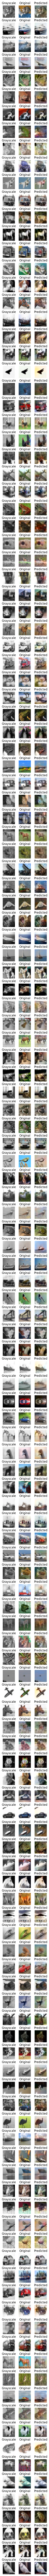

In [12]:
# Define the number of samples to generate
n_samples = 150
# Generate colorized versions of the first n_samples grayscale images in the test set
Y_hat = generator(X_test[:n_samples])

# Define the number of rows in the grid, which is equal to the number of samples
num_rows = len(Y_hat)

# Define the number of columns in the grid and the size of each image
num_cols = 3  # Number of columns in the grid
img_size = 1  # Size of each image in the grid

# Create a grid of subplots with num_rows rows and num_cols columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * img_size, num_rows * img_size))
fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust spacing between subplots

# Loop over the grayscale images, original color images, and colorized images
for row, (x, y, y_hat) in enumerate(zip(X_test[:n_samples], Y_test[:n_samples], Y_hat)):

    # Convert the original color image from Lab to RGB
    orig_lab = np.dstack((x, y * 128))
    orig_rgb = lab2rgb(orig_lab)

    # Convert the grayscale image from Lab to RGB
    grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
    grayscale_rgb = lab2rgb(grayscale_lab)

    # Convert the colorized image from Lab to RGB
    predicted_lab = np.dstack((x, y_hat * 128))
    predicted_rgb = lab2rgb(predicted_lab)

    # Display the grayscale image in the first column of the current row
    ax = axes[row, 0]  # Get the appropriate axis for the current subplot
    ax.axis('off')  # Turn off axis labels
    ax.imshow(grayscale_rgb)
    ax.set_title('Grayscale')

    # Display the original color image in the second column of the current row
    ax = axes[row, 1]  # Move to the next column for original RGB
    ax.axis('off')
    ax.imshow(orig_rgb)
    ax.set_title('Original')

    # Display the colorized image in the third column of the current row
    ax = axes[row, 2]  # Move to the next column for predicted colorized image
    ax.axis('off')
    ax.imshow(predicted_rgb)
    ax.set_title('Predicted')

    # Print the current row number to the console
    sys.stdout.flush()
    sys.stdout.write('\r{} / {}'.format(row + 1, num_rows))

# Hide empty subplots if any
for ax_row in axes:
    for ax in ax_row:
        if not ax.has_data():
            ax.axis('off')

# Adjust the padding between subplots
plt.tight_layout(pad=0.5)
# Save the figure as an image file
plt.savefig(os.path.join(WORKDIR, 'results', 'image_grid.png'))
# Display the figure
plt.show()

## Save the Generator and Discriminator Trained Models

In [13]:
# Save the checkpoints of the models and optimizers so that they can be loaded later
# Save the generator model in the SavedModel format
tf.saved_model.save(generator, os.path.join(WORKDIR, "generator-saved-model"))

# Save the discriminator model in the SavedModel format
tf.saved_model.save(discriminator, os.path.join(WORKDIR, "disciminator-saved-model"))

INFO:tensorflow:Assets written to: GANWorkspace\generator-saved-model\assets


INFO:tensorflow:Assets written to: GANWorkspace\generator-saved-model\assets


INFO:tensorflow:Assets written to: GANWorkspace\disciminator-saved-model\assets


INFO:tensorflow:Assets written to: GANWorkspace\disciminator-saved-model\assets


In [14]:
# from google.colab import files
# files.download()

# !zip -r /content/drive.zip /content/drive
